In this competition, you are allowed to use one of the following options: Decision Trees, Rule-based Models, k-Nearest Neighbor, or Naïve Bayes Classifier. If not, you will get a 0 score.

You can use all the deep learning library (pytorch, tensorflow, etc.)

Only individual team is allowed. You should do this competition by yourself.

You must submit your training code to the PLMS. TAs can check whether your code reproduces the results or not. Any significant differences in the reproduced results will result in severe penalties.

If anything that violates the honor code is found, TAs will contact you. If you cannot answer reasonably, you will get severe penalties.

**Evaluation criteria : Weighted F1 score**

**In the classification task, your goal is to predict the position of the player. (Column ‘position’ in csv file)**

### Import modules

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from scipy import stats
from sklearn.manifold import TSNE

### Define and preprocessing Dataset

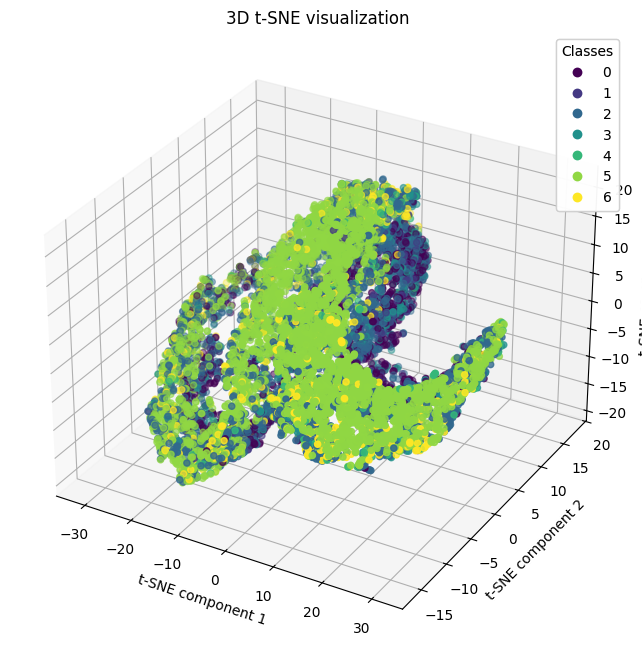

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
# train_df['ShootingEfficiency'] = train_df['FG_PCT'] * train_df['FG3_PCT']
# train_df['TotalAttempts'] = train_df['FGA'] + train_df['FG3A'] + train_df['FTA']
train_df.dropna(inplace=True)
# train_df.fillna(train_df.mean(), inplace=True)

# z_scores = np.abs(stats.zscore(train_df.select_dtypes(include=[np.number])))
# train_df = train_df[(z_scores < 3).all(axis=1)]

# X = train_df.drop(['position', 'SEASON_ID', 'TEAM_ID', 'PLAYER_AGE', 'MIN'], axis=1)
X = train_df.drop(['position', 'SEASON_ID', 'TEAM_ID'], axis=1)
y = train_df['position']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(X)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=y_encoded, cmap='viridis', marker='o')
legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)
ax.set_title('3D t-SNE visualization')
ax.set_xlabel('t-SNE component 1')
ax.set_ylabel('t-SNE component 2')
ax.set_zlabel('t-SNE component 3')
plt.show()

X_train, X_val, y_train, y_val = train_test_split(X_tsne, y_encoded, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

### Decision Tree

In [42]:
dt = DecisionTreeClassifier(random_state=42)
param_grid_dt = {
    'max_depth': [None, 3, 5, 10, 20],
    'min_samples_split': [2, 5, 10, 15, 20, 30]
}
grid_dt = GridSearchCV(dt, param_grid_dt, scoring='f1_weighted', cv=skf)
grid_dt.fit(X_train, y_train)

print(f'Decision Tree Best parameters: {grid_dt.best_params_}, Best Score: {grid_dt.best_score_}')

best_dt_model = grid_dt.best_estimator_
y_val_pred = best_dt_model.predict(X_val)

val_f1_score = f1_score(y_val, y_val_pred, average='weighted')
print(f'Validation Weighted F1 Score: {val_f1_score}')

Decision Tree Best parameters: {'max_depth': 10, 'min_samples_split': 30}, Best Score: 0.5159417704753438
Validation Weighted F1 Score: 0.5163926455444703


### kNN

In [43]:
knn = KNeighborsClassifier()
param_grid_knn = {
    'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev']
}
grid_knn = GridSearchCV(knn, param_grid_knn, scoring='f1_weighted', cv=skf)
grid_knn.fit(X_train, y_train)

print(f'K-Nearest Neighbors Best parameters: {grid_knn.best_params_}, Best Score: {grid_knn.best_score_}')

best_knn_model = grid_knn.best_estimator_
y_val_pred = best_knn_model.predict(X_val)

val_f1_score = f1_score(y_val, y_val_pred, average='weighted')
print(f'Validation Weighted F1 Score: {val_f1_score}')

K-Nearest Neighbors Best parameters: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}, Best Score: 0.5396624665315948
Validation Weighted F1 Score: 0.5427034388723918


### Naive Bayes classifier

In [44]:
nb = GaussianNB()
param_grid_nb = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}
grid_nb = GridSearchCV(nb, param_grid_nb, scoring='f1_weighted', cv=skf)
grid_nb.fit(X_train, y_train)
print(f'Naive Bayes Best parameters: {grid_nb.best_params_}, Best Score: {grid_nb.best_score_}')

best_nb_model = grid_nb.best_estimator_
y_val_pred = best_nb_model.predict(X_val)

val_f1_score = f1_score(y_val, y_val_pred, average='weighted')
print(f'Validation Weighted F1 Score: {val_f1_score}')

Naive Bayes Best parameters: {'var_smoothing': 1e-09}, Best Score: 0.39297101777061577
Validation Weighted F1 Score: 0.39515024811873734


### Rule based classifier

In [45]:
# Rule-based classifier using DecisionTreeClassifier with specific rules
rule_based_clf = DecisionTreeClassifier(random_state=42)
param_grid_rule_based = {
	'max_depth': list(range(1, 20)),
	'min_samples_split': [2, 3, 4, 5, 10]
}
grid_rule_based = GridSearchCV(rule_based_clf, param_grid_rule_based, scoring='f1_weighted', cv=skf)
grid_rule_based.fit(X_train, y_train)

print(f'Rule-based Classifier Best parameters: {grid_rule_based.best_params_}, Best Score: {grid_rule_based.best_score_}')

best_rule_based_model = grid_rule_based.best_estimator_
y_val_pred = best_rule_based_model.predict(X_val)

val_f1_score = f1_score(y_val, y_val_pred, average='weighted')
print(f'Rule-based Classifier Validation Weighted F1 Score: {val_f1_score}')

Rule-based Classifier Best parameters: {'max_depth': 10, 'min_samples_split': 4}, Best Score: 0.515130174889687
Rule-based Classifier Validation Weighted F1 Score: 0.5235400755889803


### Predict test data

In [ ]:
X_test = test_df.drop(['ID', 'SEASON_ID', 'TEAM_ID'], axis=1)
X_test = X_test.reindex(columns=X.columns, fill_value=0)

tsne = TSNE(n_components=3, random_state=42)
X_test_tsne = tsne.fit_transform(X_test)

X_test_tsne = scaler.transform(X_test_tsne)

models = {
    'DT': best_dt_model,
    'kNN': best_knn_model,
    'NB': best_nb_model,
    'Rule-based': best_rule_based_model
}

for name, model in models.items():
    y_test_pred = model.predict(X_test_tsne)
    y_test_pred_decoded = label_encoder.inverse_transform(y_test_pred)
    submission_df = pd.DataFrame({'ID': test_df['ID'], 'position': y_test_pred_decoded})
    submission_file_path = f'submission_{name}.csv'
    submission_df.to_csv(submission_file_path, index=False)
    print(f"{name} Done.")



DT Done.
kNN Done.
NB Done.
Rule-based Done.


### Visualize

Decision Tree Weighted F1 Score: 0.5163926455444703
Naive Bayes Weighted F1 Score: 0.39515024811873734
K-Nearest Neighbors Weighted F1 Score: 0.5427034388723918
Rule based Classifier Weighted F1 Score: 0.5235400755889803


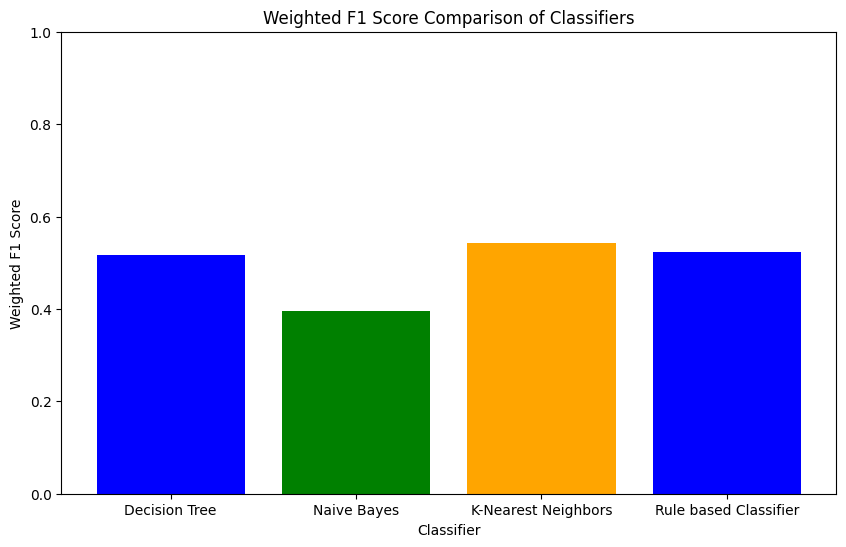

In [47]:
# Evaluate each model and store F1 scores
models = {'Decision Tree': best_dt_model, 'Naive Bayes': best_nb_model, 'K-Nearest Neighbors': best_knn_model, 'Rule based Classifier': best_rule_based_model}
f1_scores = {}
for name, model in models.items():
    y_pred = model.predict(X_val)
    score = f1_score(y_val, y_pred, average='weighted')
    f1_scores[name] = score
    print(f'{name} Weighted F1 Score: {score}')
    # print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))

# Plot F1 scores of each classifier
plt.figure(figsize=(10, 6))
plt.bar(f1_scores.keys(), f1_scores.values(), color=['blue', 'green', 'orange'])
plt.title('Weighted F1 Score Comparison of Classifiers')
plt.xlabel('Classifier')
plt.ylabel('Weighted F1 Score')
plt.ylim(0, 1)
plt.show()
